# EE 467 Lab 2: Breaking CAPTCHAs with Tensorflow / Keras
In lab 2, we are going to work on automatically breaking CAPTCHAs with deep learning! Originally, CAPTCHA stands for "Completely Automated Public Turing test to tell Computers and Humans Apart", and traditional CAPCTHAs serve as a great tool to stop spam bots and malicious crawlers. Today, as we have made huge progress in computer vision and deep learning, these CAPCTHAs are no longer unbreakable by computers. Now let's prove the correctness of the claim by ourselves!

As usual, please check if the helper library, `lab_2_helpers.py` and the extracted dataset directory, `captcha-images` exist under the same directory. Then, please install all libraries used for this lab:

In [24]:
%pip install matplotlib scikit-learn "opencv-python>4" imutils

# Install Tensorflow with CPU support only, or ...
%pip install "tensorflow>2"
# Install Tensorflow with GPU support:
#%pip install tensorflow-gpu>2

Next, we import all tools needed before starting:

In [25]:
import os, pickle, glob, math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
from tensorflow.keras import Sequential, layers
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from lab_2_helpers import *

# Preprocessing
## Ground Truth Characters Extraction
As usual, we will start pre-processing stage by loading CAPTCHA images into the memory:

In [26]:
!tar -xJf captcha-images.tar.xz

In [27]:
# Dataset images folder
CAPTCHA_IMAGE_FOLDER = "./captcha-images"

# List of all the captcha images we need to process
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
# Review image paths
pprint(captcha_image_paths[:10])

['./captcha-images/C4F7.png',
 './captcha-images/7VWM.png',
 './captcha-images/B4FA.png',
 './captcha-images/3EFX.png',
 './captcha-images/C2Z6.png',
 './captcha-images/2QP5.png',
 './captcha-images/G9ES.png',
 './captcha-images/3DDY.png',
 './captcha-images/B7N3.png',
 './captcha-images/5WGG.png']


Note that for each image, its file name (without extension) happens to be its corresponding CAPTCHA text. Thus, we extract file names for all CAPTCHA images and save them as labels for future use:

In [28]:
def extract_captcha_text(image_path):
    """ Extract correct CAPTCHA texts from file name of images. """
    # Extract file name of image from its path
    # e.g. "./captcha-images/2A2X.png" -> "2A2X.png"
    image_file_name = os.path.basename(image_path)
    # Extract base name of image, omitting file extension
    # e.g. "2A2X.png" -> "2A2X"
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
# Review extraction results
pprint(captcha_texts[:10])

['C4F7', '7VWM', 'B4FA', '3EFX', 'C2Z6', '2QP5', 'G9ES', '3DDY', 'B7N3', '5WGG']


## Loading and Transforming Images
For the feature extraction stage, we are going to extract individual characters from these CAPTCHAs. This is done by looking for contours (bounding boxes) around characters, then cropping the CAPTCHAs such as only the contour areas are preserved. We begin feature extraction by loading and transforming images:

Figure(2000x500)


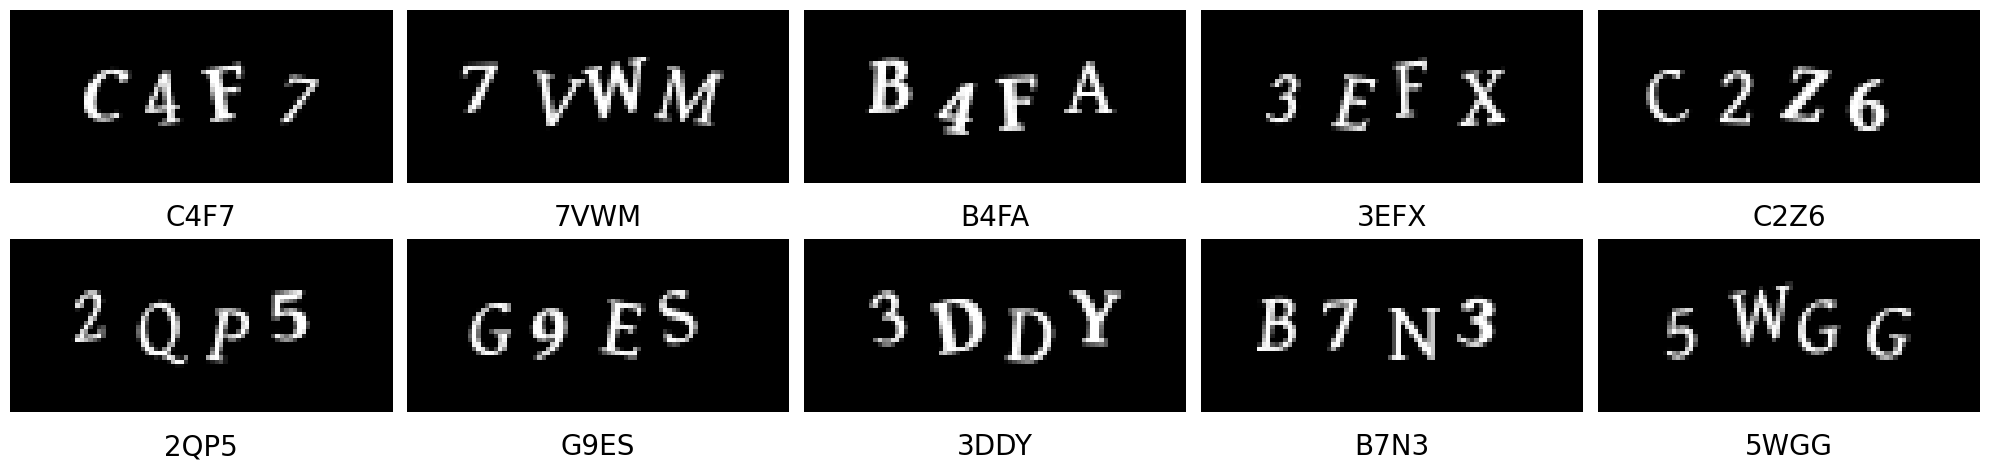

In [29]:
import cv2

def load_transform_image(image_path):
    """ Load and transform image into grayscale. """
    ## [ TODO ]
    # 1) Load image with OpenCV
    image = cv2.imread(image_path)
    # 2) Convert image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 3) Add extra padding (8px) around the image
    image_padded = cv2.copyMakeBorder(image_gray, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=255)

    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]
# Review loaded CAPTCHAs
print_images(
    captcha_images[:10], n_rows=2, texts=captcha_texts[:10]
)

Next, we will split our dataset into train-validation set and test set. The former set will be used for training and validation in deep character classification model, while the latter will be used for testing our CAPTCHA recognition pipline end-to-end:

In [30]:
# Train-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Perform split on CAPTCHA images as well as labels
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


## Bounding Box Extraction
It's now time to perform the most important feature extraction step: finding contours and extracting characters. Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. It is useful for shape analysis and object detection and recognition. For our task however, we are **more interested in the bounding boxes around characters**, since these are the part of images we will be used for character classification:

![char-contours.png](attachment:char-contours.png)

Here are the steps we are going to perform:

* Find contours around characters in CAPTCHAs.
* Get the position and size for each corresponding bounding box.
* If a bounding box is too wide (width-to-height ratio larger than 1.25), chances are that we have bounded two letters in a single bounding box. In this case, split the bounding box vertically from the center into two.
* Store all bounding boxes for the CAPTCHA.
* If there aren't 4 bounding boxes for the CAPTCHA, ignore it since our character extraction process must have run into problems in this case.
* Sort the bounding boxes by their X coordinates, so that they match the order corresponding letters occur.
* For each bounding box, extract corresponding region of the image, and store it as an instance of corresponding character at `${CHAR_IMAGE_FOLDER}/{letter}/{count}.png`.

After these steps, we have transformed CAPTCHA images into images of single character. This simplifies our task since now our model only needs to deal with classification (from character image to character itself) rather than also dealing with detection (finding and extracting charatcers).

In [31]:
# Character images folder template
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    """ Find contours and extract characters inside each CAPTCHA. """

    # Threshold image and convert it to black-white
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Find contours (continuous blobs of pixels) the image
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    char_regions = []
    # Loop through each contour
    for contour in contours:
        # Get the rectangle that contains the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Compare the width and height of the bounding box,
        # detect if there are letters conjoined into one chunk

        if w / h > 1.25:
            # Bounding box is too wide for a single character
            # Split it in half into two letter regions
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            # Only a single letter in contour
            char_regions.append((x, y, w, h))

    # Ignore image if less or more than 4 regions detected
    if len(char_regions)!=4:
        return None
    # Sort regions by their X coordinates
    char_regions.sort(key=lambda x: x[0])

    # Character images
    char_images = []
    # Save each character as a single image
    for x, y, w, h in char_regions:
        # Extract character from image with 2px margin
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        # Save character images
        char_images.append(char_image)

    # Return character images
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    """ Save character images to directory. """
    for char_image, char in zip(char_images, captcha_text):
        # Get the folder to save the image in
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)

        # Write letter image to file
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)

        # Update count
        char_counts[char] = char_count+1

# Force character extraction even if results are already available
FORCE_EXTRACT_CHAR = False

char_counts = {}
# Extract and save images for characters
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        # Extract character images
        char_images = extract_chars(captcha_image)
        # Skip if extraction failed
        if char_images is None:
            continue
        # Save character images
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

## Label Encoding
During the training stage, we are going to load character images from previous stages as features and generate corresponding labels from their path. We will then rescale features, one-hot encode labels (occurred characters) and save labels to an external file.

In [32]:
# Path of occurred characters (labels)
LABELS_PATH = "./labels.pkl"

def make_feature(image):
    """ Process character image and turn it into feature. """
    # Resize letter to 20*20
    image_resized = resize_to_fit(image, 20, 20)
    # Add extra dimension as the only channel
    feature = image_resized[..., None]

    return feature

def make_feature_label(image_path):
    """ Load character image and make feature-label pair from image path. """
    # Load image and make feature
    feature = make_feature(cv2.imread(image_path, cv2.COLOR_BGR2GRAY))
    # Extract label based on the directory the image is in
    label = image_path.split(os.path.sep)[-2]

    return feature, label

# Get all image paths from the character folder
char_image_paths = list(paths.list_images(CHAR_IMAGE_FOLDER))
print(char_image_paths)
if not char_image_paths:
    print(f"Warning: No character images found in '{CHAR_IMAGE_FOLDER}'. "
          "This usually means the character extraction step in the previous cell was skipped or failed. "
          "Please ensure the 'FORCE_EXTRACT_CHAR' flag in the previous cell is set to True or the folder is correctly populated.")
    features_tv = []
    labels_tv = []
else:
    # Make features and labels from character image paths
    # Assuming unzip returns two lists (or iterables) if given a non-empty iterable
    features_tv, labels_tv = unzip((
        make_feature_label(image_path) for image_path in char_image_paths
    ))

# Scale raw pixel values into range [0, 1]
# Check if features_tv is empty to prevent errors with np.array
if features_tv:
    features_tv = np.array(features_tv, dtype="float") / 255
else:
    features_tv = np.array([]) # Ensure it's an empty numpy array

# Convert labels into one-hot encodings
# Check if labels_tv is empty to prevent errors with LabelBinarizer
if labels_tv:
    lb = LabelBinarizer()
    labels_one_hot_tv = lb.fit_transform(labels_tv)
    # Number of classes
    n_classes = len(lb.classes_)

    # Further split the training data into training and validation set
    X_train, X_vali, y_train, y_vali = train_test_split(
        features_tv, labels_one_hot_tv, test_size=0.25, random_state=955996
    )
    # Save mapping from labels to one-hot encoding
    with open(LABELS_PATH, "wb") as f:
        pickle.dump(lb, f)
else:
    print("Error: Cannot proceed with training as no labels were generated. Set `n_classes`, `lb`, `labels_one_hot_tv`, `X_train`, `X_vali`, `y_train`, `y_vali` to default empty values.")
    # Initialize these to empty or default values to avoid further errors
    lb = None
    labels_one_hot_tv = np.array([])
    n_classes = 0
    X_train, X_vali, y_train, y_vali = np.array([]), np.array([]), np.array([]), np.array([])


['./char-images-31528476/C/15.png', './char-images-31528476/C/47.png', './char-images-31528476/C/94.png', './char-images-31528476/C/52.png', './char-images-31528476/C/70.png', './char-images-31528476/C/51.png', './char-images-31528476/C/83.png', './char-images-31528476/C/50.png', './char-images-31528476/C/108.png', './char-images-31528476/C/24.png', './char-images-31528476/C/30.png', './char-images-31528476/C/100.png', './char-images-31528476/C/54.png', './char-images-31528476/C/32.png', './char-images-31528476/C/21.png', './char-images-31528476/C/76.png', './char-images-31528476/C/69.png', './char-images-31528476/C/41.png', './char-images-31528476/C/81.png', './char-images-31528476/C/25.png', './char-images-31528476/C/3.png', './char-images-31528476/C/34.png', './char-images-31528476/C/104.png', './char-images-31528476/C/38.png', './char-images-31528476/C/4.png', './char-images-31528476/C/2.png', './char-images-31528476/C/67.png', './char-images-31528476/C/10.png', './char-images-3152

# Training
Next, we build a Convolutional Neural Network (CNN) as our classification model with Tensorflow / Keras. The structure of the neural network is shown below:

![conv-net-structure.png](attachment:conv-net-structure.png)

After building the neural network, we train it and save weights.

In [51]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

def to_torch_images(X_np):
    X = torch.tensor(X_np, dtype=torch.float32)
    # TF (N, 20, 20, 1) -> Torch (N, 1, 20, 20)
    if X.ndim == 4 and X.shape[-1] == 1:
        X = X.permute(0, 3, 1, 2).contiguous()
    # If (N, 20, 20) -> (N, 1, 20, 20)
    if X.ndim == 3:
        X = X.unsqueeze(1)
    return X

def to_class_indices(y_np):
    y = torch.tensor(y_np)
    # one-hot (N, n_classes) -> indices (N,)
    if y.ndim == 2:
        y = torch.argmax(y, dim=1)
    return y.long()

# DataLoaders (train + validation)
Xtr = to_torch_images(X_train)
ytr = to_class_indices(y_train)
Xva = to_torch_images(X_vali)
yva = to_class_indices(y_vali)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=BATCH_SIZE, shuffle=True)
vali_loader  = DataLoader(TensorDataset(Xva, yva), batch_size=BATCH_SIZE, shuffle=False)

# Loss + optimizer (TF: categorical_crossentropy + Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training (mirrors TF: fit(...), then save_weights / load_weights)
if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    for epoch in range(N_EPOCHS):
        model.train()
        running_loss = 0.0
        total = 0

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(Xb)              # logits (no softmax)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * Xb.size(0)
            total += Xb.size(0)

        train_loss = running_loss / total
        print(f"Epoch {epoch+1}/{N_EPOCHS} - train_loss: {train_loss:.4f}")

    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
else:
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=device))

Epoch 1/10 - train_loss: 0.0058
Epoch 2/10 - train_loss: 0.0000
Epoch 3/10 - train_loss: 0.0000
Epoch 4/10 - train_loss: 0.0000
Epoch 5/10 - train_loss: 0.0000
Epoch 6/10 - train_loss: 0.0000
Epoch 7/10 - train_loss: 0.0000
Epoch 8/10 - train_loss: 0.0000
Epoch 9/10 - train_loss: 0.0000
Epoch 10/10 - train_loss: 0.0000


# Evaluation
During the training part, we have validated the performance of our neural network model on images of single characters. Now it's time to test and evaluate CAPTCHAs from the beginning to the end. First, we will need to build the pipeline for CAPTCHA character prediction:

In [52]:
model.eval()
criterion = nn.CrossEntropyLoss()

total = 0
correct = 0
loss_sum = 0.0

with torch.no_grad():
    for Xb, yb in vali_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        loss_sum += loss.item() * Xb.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += Xb.size(0)

val_loss = loss_sum / total
val_acc = correct / total

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

Validation loss: 0.1041
Validation accuracy: 0.9933


Now, we can compute the accuracy of our pipeline, as well as taking a look at correct and incorrect CAPTCHA text predictions:

In [53]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# --- Build idx_to_char mapping (choose ONE path) ---
# Path A: using LabelBinarizer from your preprocessing
idx_to_char = {i: c for i, c in enumerate(lb.classes_)}

# Path B: if you don't have lb, uncomment and set your exact character set
# characters = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# idx_to_char = {i: ch for i, ch in enumerate(characters)}

def prep_char_tensor(char_img, target_w=20, target_h=20):
    """char_img -> torch.FloatTensor shape (1, 1, 20, 20), normalized to [0,1]."""
    img = resize_to_fit(char_img, target_w, target_h)

    # If image is RGB, convert to grayscale (defensive)
    if isinstance(img, np.ndarray) and img.ndim == 3:
        # simple luminance-ish conversion
        img = img[..., 0] * 0.299 + img[..., 1] * 0.587 + img[..., 2] * 0.114

    img = img.astype("float32") / 255.0
    t = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    return t

def predict_captcha_text(model, captcha_img):
    """
    Predict full CAPTCHA string by:
    1) extracting 4 chars
    2) running model on the 4 chars
    3) joining predicted characters
    Returns predicted string, or None if extraction failed.
    """
    char_imgs = extract_chars(captcha_img)
    if char_imgs is None or len(char_imgs) == 0:
        return None

    # Build batch: (num_chars,1,20,20)
    batch = torch.cat([prep_char_tensor(ci) for ci in char_imgs], dim=0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(batch)                  # (num_chars, n_classes)
        ids = torch.argmax(logits, dim=1)      # (num_chars,)
        pred = "".join(idx_to_char[i.item()] for i in ids)

    return pred

N_DISPLAY_SAMPLES = 10

n_test = len(captcha_texts_test)
n_correct = 0
n_extraction_fail = 0

correct_indices = []
incorrect_indices = []
preds_test = []

for i, (img, actual_text) in enumerate(zip(captcha_images_test, captcha_texts_test)):
    pred_text = predict_captcha_text(model, img)

    # If char extraction fails, treat as incorrect (or you can skip; your choice)
    if pred_text is None:
        preds_test.append("")
        n_extraction_fail += 1
        if len(incorrect_indices) < N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)
        continue

    preds_test.append(pred_text)

    if pred_text == actual_text:
        n_correct += 1
        if len(correct_indices) < N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        if len(incorrect_indices) < N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("CAPTCHA-level accuracy:", n_correct / n_test)
print("# extraction failures:", n_extraction_fail)

# Optional: show a few example predictions (text-only, no images)
print("\nExamples (first 10):")
for i in range(min(10, n_test)):
    print(f"{i:03d}  pred={preds_test[i]!r}   actual={captcha_texts_test[i]!r}")

# of test CAPTCHAs: 228
# correctly recognized: 219
CAPTCHA-level accuracy: 0.9605263157894737
# extraction failures: 3

Examples (first 10):
000  pred='4JG9'   actual='4JG9'
001  pred='B7UX'   actual='B7UX'
002  pred=''   actual='5RBJ'
003  pred='L6U7'   actual='L6U7'
004  pred='5T6N'   actual='5T6N'
005  pred='2QP5'   actual='2QP5'
006  pred='C2F3'   actual='C2F3'
007  pred='J2QE'   actual='J2QE'
008  pred='E7KU'   actual='E7KU'
009  pred='7U9G'   actual='7U9G'


### Open-Ended Extension:

TensorFlow is one popular framework for implementing Deep Neural Networks, and another widely used framework is **PyTorch**. After you successfully complete this lab:

- Use your favorite language model and/or coding assistant (e.g., **GPT**, **Copilot**, **Gemini**, **Cursor**, etc.) to **convert your TensorFlow CNN implementation into PyTorch**.
- Repeat the same training + evaluation experiments in PyTorch.
- You should observe **similar results** (minor differences are expected due to randomness and implementation details).

✅ **Submission Requirement:**  
Include this as a **separate notebook** in your lab-submission GitHub repository named:

**`Breaking-CAPTCHAS-Pytorch.ipynb`**


## References
1. How to break a CAPTCHA system in 15 minutes with Machine Learning: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710
2. CaptchaSolver Jupyter Notebook: https://github.com/BenjaminWegener/CaptchaSolver
3. Keras Tutorial: The Ultimate Beginner's Guide to Deep Learning in Python: https://elitedatascience.com/keras-tutorial-deep-learning-in-python
4. Keras API reference: https://keras.io/
5. Tensorflow API reference: https://www.tensorflow.org/api_docs